In [ ]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [1]:
from typing import Callable, List, Tuple
from pathlib import Path

import os, shutil, pickle, collections
import torch
import torchvision
from torch import nn

from torchvision import transforms as T
import torch.utils.data as D

import catalyst
from catalyst import utils

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import numba, cv2, gc
import matplotlib.pyplot as plt

from segmentation_models_pytorch import FPN
import segmentation_models_pytorch as smp

from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm

from catalyst.dl import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback, CheckpointCallback
from catalyst.contrib.callbacks import DrawMasksCallback

In [2]:
print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.7.0, catalyst: 20.12


### Paths and base functions

In [3]:
DATA_PATH = Path('/home/jupyter/data/')
assert DATA_PATH.exists()

In [4]:
REPORT_PATH = Path('/home/jupyter/reports')
if not REPORT_PATH.exists():
    os.makedirs(REPORT_PATH)
assert REPORT_PATH.exists()

In [5]:
EXPERIMENT_NAME = '33_pytorch_fpn_efficientnet_b6_1024_2shifted_slices_groupkfold_fastai'

In [6]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    splits = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (splits[0:][::2], splits[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype='uint8')
    for lo, hi in zip(starts, ends):
        img[lo: hi] = 1
    return img.reshape(shape, order='F') # Fortran order reshaping

In [7]:
@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(1)
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if len(points) % 2 == 0:
                points.append(i+1)
            else:
                points.append(i+1 - points[-1])
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

In [8]:
def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

In [9]:
train_df = pd.read_csv(DATA_PATH / 'train.csv', index_col=[0])
train_df

encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...

In [10]:
MASK_PATH = Path('/home/jupyter/ds_cache')
!mkdir {MASK_PATH}

def reset_mask_path():
    shutil.rmtree(MASK_PATH)

mkdir: cannot create directory ‘/home/jupyter/ds_cache’: File exists


### Dataset

In [11]:
WINDOW = 1024 # tile size
MIN_OVERLAP = 32
NEW_SIZE = 512 # size after re-size which are fed to the model
THRESHOLD = 0
CONTENT_THRESHOLD = 0.04

In [12]:

# Used to filter tiles with enough color information in it
def is_tile_contains_info(img, pixel_limits = (50, 220), content_threshold = CONTENT_THRESHOLD, expected_shape = (WINDOW, WINDOW, 3)):
    """
    img: np.array
    pixel_limits: tuple
    content_threshold: float percents
    expected_shape: tuple
    """
    
    left_limit = np.prod(img > pixel_limits[0], axis=-1)
    right_limit =  np.prod(img < pixel_limits[1], axis=-1)

    if img.shape != expected_shape:
        print('img.shape != expected_shape', img.shape)
        return False, 0.

    percent_of_pixels = np.sum(left_limit*right_limit) / (img.shape[0] * img.shape[1])
    return  percent_of_pixels > content_threshold, percent_of_pixels

In [13]:
# identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
identity = None
# normalize_transform = T.Normalize([0.625, 0.448, 0.688], [0.131, 0.177, 0.101])
# normalize_transform = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# normalize_transform = T.Normalize([0.65459856,0.48386562,0.69428385], [0.15167958,0.23584107,0.13146145])
normalize_transform = T.Normalize([0.6130, 0.4126, 0.6595], [0.1417, 0.2045, 0.1237])

def read_from_slice(dataset, x1, x2, y1, y2):
    image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2)))
    image = np.moveaxis(image, 0, -1)
    return image

class HubDataset(D.Dataset):
    def __init__(self, root_dir, transform, valid_transform=None, mode='train', window=256, overlap=32, threshold = THRESHOLD):
        self.path = root_dir
        assert self.path.exists()
        self.overlap, self.window, self.transform, self.valid_transform, self.threshold = overlap, window, transform, valid_transform, threshold
        self.mode = mode
        self.csv = pd.read_csv(self.path / 'train.csv', index_col=[0])
        self.build_slices()
        self.len = len(self.slices)
        # where do these numbers come from?
        # Better to calculate them to check if correct.
        self.as_tensor = T.Compose([
            T.ToTensor(),
            normalize_transform,
        ])
        
    def __copy__(self):
        new_ds = type(self)(
            self.path,
            self.transform,
            valid_transform=self.valid_transform,
            mode=self.mode,
            window=self.window,
            overlap=self.overlap,
            threshold=self.threshold
        )
        new_ds.masks = self.masks
        new_ds.files = self.files
        new_ds.slices = self.slices
        new_ds.skipped = self.skipped
        return new_ds
        
    def build_slices(self):
        self.masks = []; self.files = []; self.slices = []
        self.skipped = 0
        slices_path = MASK_PATH/f'slices.pkl'
        files_path = MASK_PATH/f'files.pkl'
        masks_path = MASK_PATH/f'masks.pkl'
        if not slices_path.exists():
            for i, filename in tqdm(enumerate(self.csv.index), total = len(self.csv)):
                filepath = self.path/'train'/f'{filename}.tiff'
                assert filepath.exists()
                self.files.append(filepath)
                with rasterio.open(filepath) as dataset:
                    self.build_slice(dataset, filename, i)
            with open(slices_path, "wb") as filehandler:
                pickle.dump(self.slices, filehandler)
            with open(files_path, "wb") as filehandler:
                pickle.dump(self.files, filehandler)
            with open(masks_path, "wb") as filehandler:
                pickle.dump(self.masks, filehandler)
        else:
            print('Reading cached slices, files and masks')
            with open(slices_path,'rb') as file:
                self.slices = pickle.load(file)
            with open(files_path,'rb') as file:
                self.files = pickle.load(file)
            with open(masks_path,'rb') as file:
                self.masks = pickle.load(file)
                
    
                        
    def build_slice(self, dataset, filename, i):
        dataset_shape = dataset.shape
        self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset_shape))
        slices = make_grid(dataset_shape, window = self.window, min_overlap = self.overlap)

        # Shifting slices to the right and bottom and adding to the original slices
        slices_copy = slices.copy()
        slices_copy_y = slices.copy()
#         # horizontal
        slices_copy[:,(0,1)] += WINDOW // 2 # shift
        slices = np.concatenate ([slices, slices_copy])
#         # vertical
        slices_copy_y[:,(2,3)] += WINDOW // 2
        slices = np.concatenate ([slices, slices_copy_y])
        slices = slices[~(slices[:,1] > dataset.shape[0]),:] # filter those outside of the screen
        slices = slices[~(slices[:,3] > dataset.shape[1]),:] # filter those outside of the screen

        # Only including slices above a specific threshold
        # Note: we are potentially throwing away some data here
        for slc in slices:
            x1, x2, y1, y2 = slc
            image = read_from_slice(dataset, x1, x2 , y1, y2)
            contains_info = is_tile_contains_info(image)
            if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold and contains_info[0]:
                self.slices.append([i,x1,x2,y1,y2])
            else:
                self.skipped += 1
                        
                        
    def apply_transform(self, image, mask):
        augments = self.transform(image=image, mask=mask) if self.mode == 'train' else self.valid_transform(image=image, mask=mask)
        image = self.as_tensor(augments['image'])
        mask = augments['mask'][None]
        return image, torch.from_numpy(mask).to(torch.float16)
        
    def __getitem__(self, index):
        image_path = MASK_PATH/f'image_{index}'
        mask_path = MASK_PATH/f'mask_{index}'
        if not image_path.exists():
            idx = self.slices[index][0]
            filename = self.files[idx]
            x1, x2, y1, y2 = self.slices[index][1:]
            with rasterio.open(filename) as dataset:
                image = read_from_slice(dataset, x1, x2, y1, y2).astype('uint8')
            mask = self.masks[idx][x1:x2,y1:y2]
            with open(image_path, "wb") as filehandler:
                pickle.dump(image, filehandler)
                if index % 100 == 0:
                    print(f'Writing to {image_path}')
            with open(mask_path, "wb") as filehandler:
                pickle.dump(mask, filehandler)
            return self.apply_transform(image, mask)
        else:
            with open(image_path,'rb') as file:
                image = pickle.load(file)
            with open(mask_path,'rb') as file:
                mask = pickle.load(file)
            return self.apply_transform(image, mask)
    
    def __len__(self):
        return self.len
    
    def __repr__(self):
        return f'total: {len(self)}, skipped: {self.skipped} mode: {self.mode}'

In [14]:
# reset_mask_path()
# !mkdir {MASK_PATH}

### Transformations

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensor

In [16]:
def pre_transforms(image_size=NEW_SIZE):
    return [A.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      A.RandomRotate90(),
      A.Cutout(),
      A.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      A.GridDistortion(p=0.3),
      A.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=NEW_SIZE):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = A.Compose([
      A.SmallestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = A.Compose([A.Resize(image_size, image_size, p=1)])

    random_crop_big = A.Compose([
      A.LongestMaxSize(pre_size, p=1),
      A.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      A.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = A.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [17]:
train_transforms = compose([
    resize_transforms(), 
    hard_transforms()
])
valid_transforms = compose([pre_transforms()])

In [18]:
def generate_ds(size):
    return HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=train_transforms, valid_transform=valid_transforms, mode='train')

ds = generate_ds(NEW_SIZE)

Reading cached slices, files and masks


In [19]:
ds

total: 5340, skipped: 0 mode: train

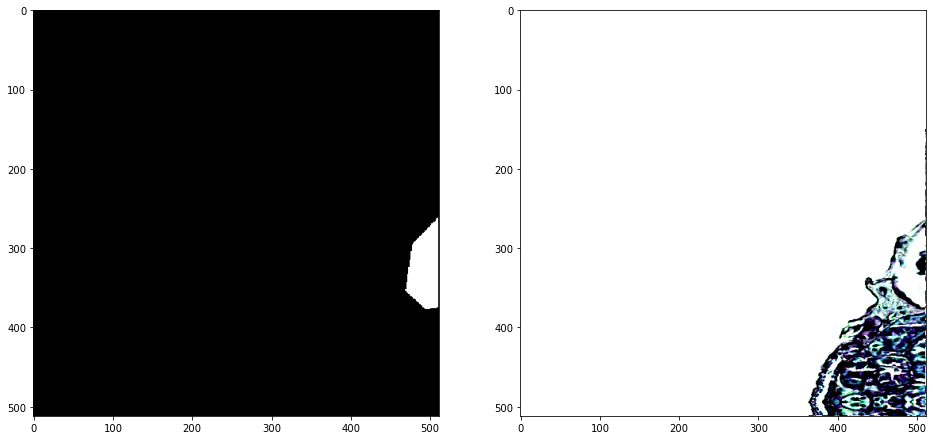

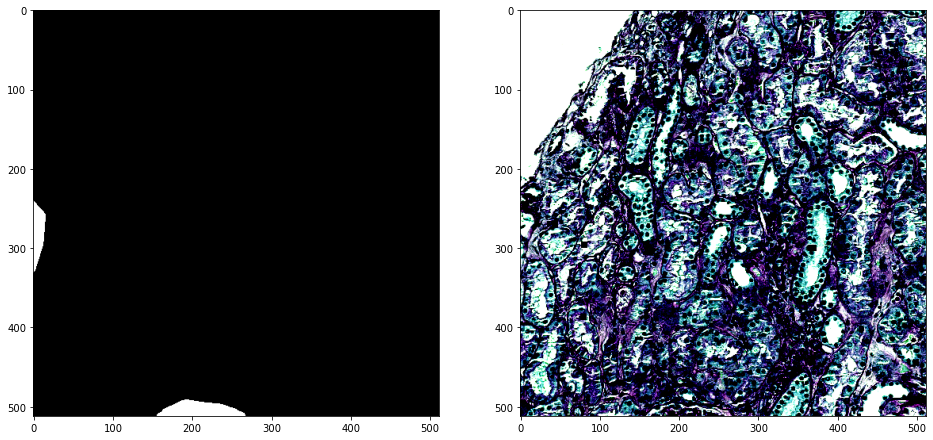

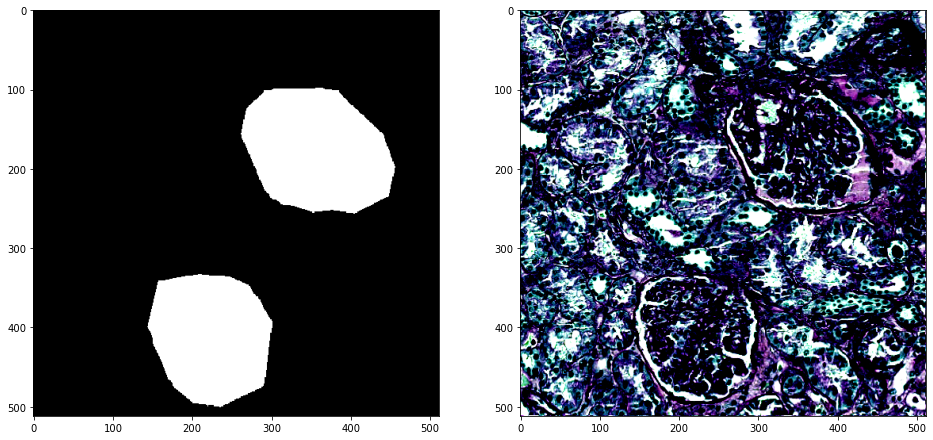

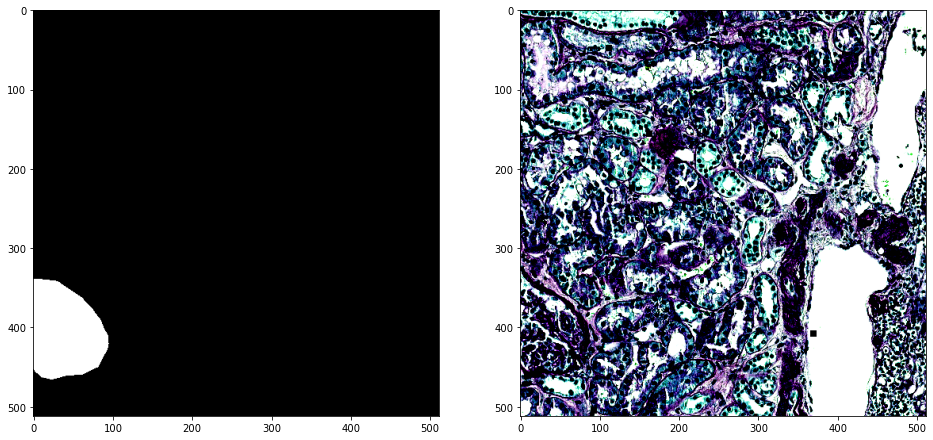

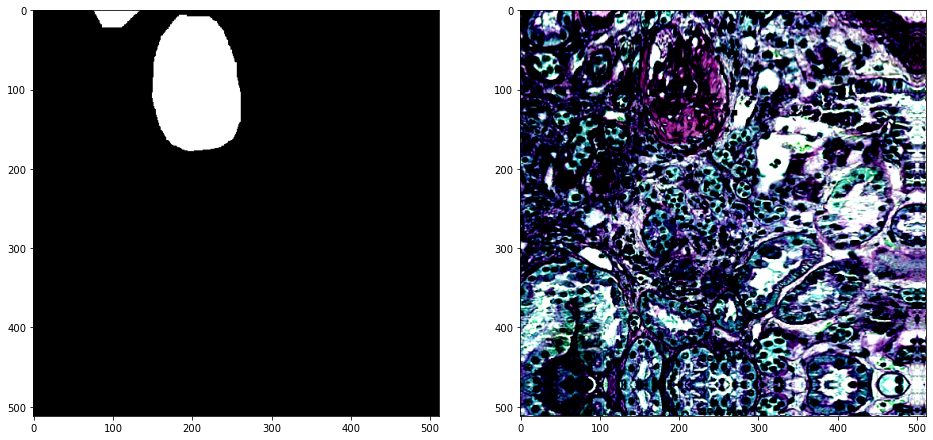

In [20]:
def display_mask_img(idx):
    image, mask = ds[idx]
    mask = mask.to(torch.uint8)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(mask[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(np.moveaxis(image.numpy(), 0, -1));

for i in range(5):
    display_mask_img(i)

In [21]:
ds.mode = 'valid'
ds

total: 5340, skipped: 0 mode: valid

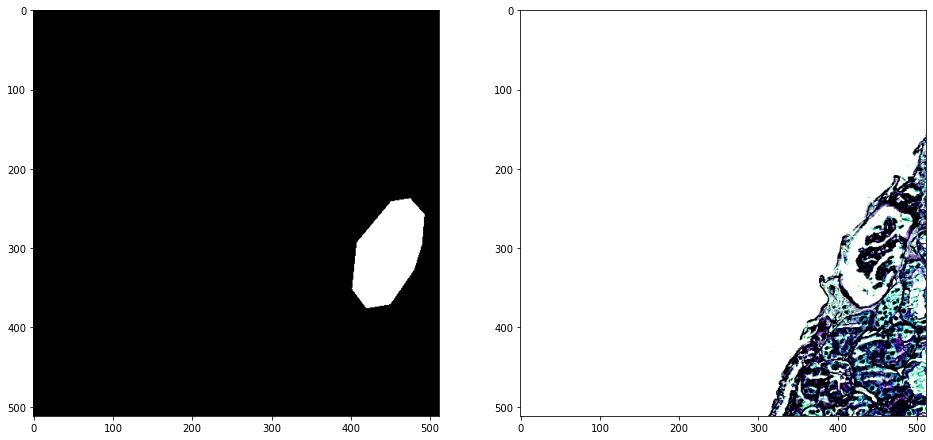

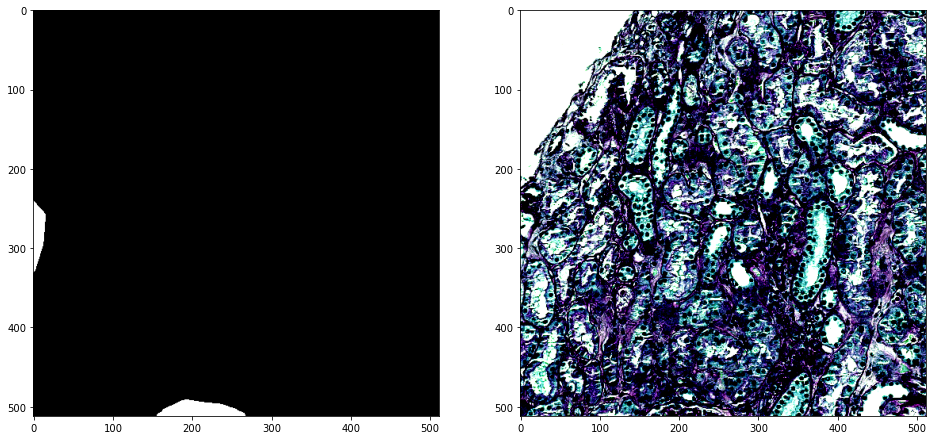

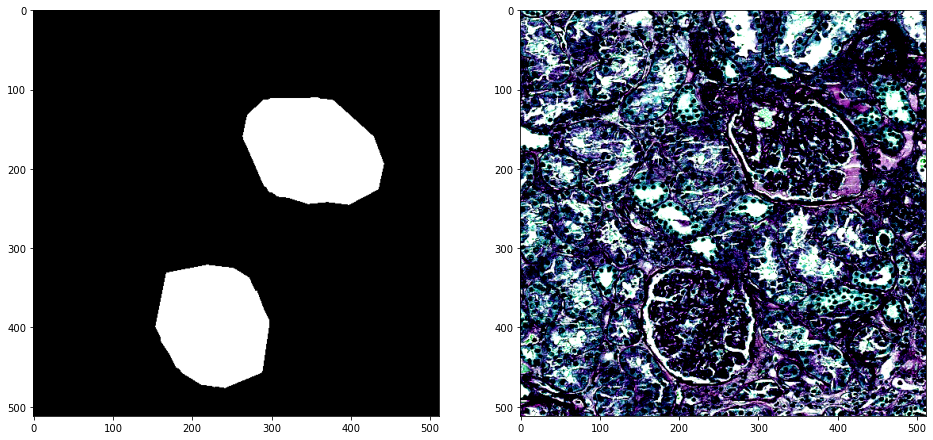

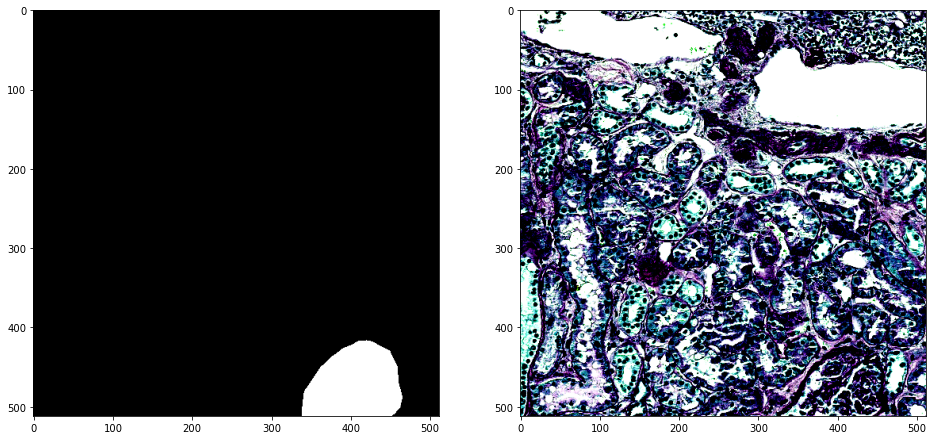

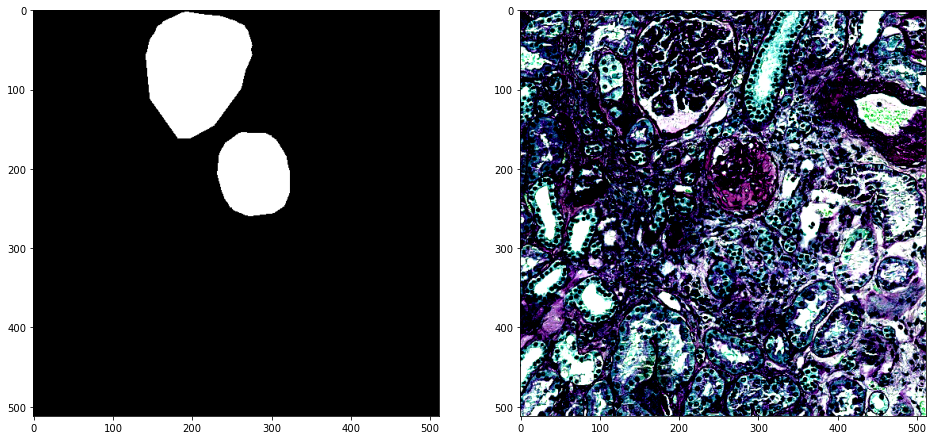

In [22]:
for i in range(5):
    display_mask_img(i)

In [23]:
ds.mode = 'train'
ds

total: 5340, skipped: 0 mode: train

#### Split

In [24]:
FOLDS = 4

In [25]:
# Images and its corresponding masks are saved with the same filename.
groups = [ds.slices[i][0] for i in range(len(ds))]

In [26]:
group_kfold = GroupKFold(n_splits = FOLDS)

#### Data loaders

In [27]:
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
import copy

def create_subset(ds, train_idx, valid_idx):
    train_ds = D.Subset(ds, train_idx)
    val_ds = copy.copy(ds)
    val_ds.mode = 'valid'
    valid_ds = D.Subset(val_ds, valid_idx)
    print(val_ds)
    return train_ds, valid_ds

In [29]:
def generate_train_valid_dls(ds, train_idx, valid_idx):
    train_ds, valid_ds = create_subset(ds, train_idx, valid_idx)

    num_workers = 0
    # define training and validation data loaders
    train_dl = D.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    valid_dl = D.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    return train_dl, valid_dl

### Model

In [30]:
ENCODER_NAME = 'efficientnet-b6'

class HuBMAPModel(nn.Module):
    def __init__(self):
        super(HuBMAPModel, self).__init__()
        self.model = FPN(encoder_name = ENCODER_NAME, 
                          encoder_weights = 'imagenet',
                          classes = 1,
                          activation = None)
        
        
    def forward(self, images):
        return self.model(images)

In [31]:
def get_model():
    return HuBMAPModel()

### Train

In [32]:
from catalyst.contrib.nn import DiceLoss, IoULoss

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}

In [33]:
from torch import optim
from catalyst.contrib.nn import RAdam, Lookahead

LR = 1e-3
encoder_learning_rate = 5e-4

def create_optimizer_scheduler(model):
    # Since we use a pre-trained encoder, we will reduce the learning rate on it.
    layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=3e-5)}

    # This function removes weight_decay for biases and applies our layerwise_params
    model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

    # Catalyst has new SOTA optimizers out of box
    base_optimizer = RAdam(model_params, lr=LR, weight_decay=0.0003)
    optimizer = Lookahead(base_optimizer)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)
    return optimizer, scheduler


In [34]:
from catalyst.dl import SupervisedRunner

EPOCHS = 12
logdir = "./logs/segmentation"

device = utils.get_device()
print(f"device: {device}")

fp16_params = dict(opt_level="O1") # params for FP16
print(f"FP16 params: {fp16_params}")

device: cuda
FP16 params: {'opt_level': 'O1'}


In [35]:
fold_info = [(train_idx, valid_idx) for fold, (train_idx, valid_idx) in tqdm(enumerate(group_kfold.split(ds.slices, 
                                                        groups = groups)), total=FOLDS)]

  0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
def create_callbacks(model_name, fold):
    callbacks = [
        # Each criterion is calculated separately.
        CriterionCallback(
            input_key="mask",
            prefix="loss_dice",
            criterion_key="dice"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_iou",
            criterion_key="iou"
        ),
        CriterionCallback(
            input_key="mask",
            prefix="loss_bce",
            criterion_key="bce"
        ),

        # And only then we aggregate everything into one loss.
        MetricAggregationCallback(
            prefix="loss",
            mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
            # because we want weighted sum, we need to add scale for each loss
            metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
        ),

        # metrics
        DiceCallback(input_key="mask"),
        IouCallback(input_key="mask"),
        # visualization
        DrawMasksCallback(output_key='logits',
                          input_image_key='image',
                          input_mask_key='mask',
                          summary_step=50
        )
    ]
    return callbacks

In [37]:
def create_model_loaders(fold):
    model = get_model()
    model.to(DEVICE)
    train_idx, valid_idx = fold_info[fold]
    print(f'Proportions valid / train: {len(valid_idx) / (len(train_idx) + len(valid_idx))}')
    train_dl, valid_dl = generate_train_valid_dls(ds, train_idx, valid_idx)    
    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_dl
    loaders["valid"] = valid_dl
    optimizer, scheduler = create_optimizer_scheduler(model)
    return model, loaders, optimizer, scheduler

In [38]:
def train(fold = 0):
    model, loaders, optimizer, scheduler = create_model_loaders(fold)
    callbacks = create_callbacks('fpn', fold)
    # by default SupervisedRunner uses "features" and "targets",
    # in our case we get "image" and "mask" keys in dataset __getitem__
    runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")
    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        # our dataloaders
        loaders=loaders,
        # We can specify the callbacks list for the experiment;
        callbacks=callbacks,
        # path to save logs
        logdir=logdir,
        num_epochs=EPOCHS,
        # save our best checkpoint by IoU metric
        main_metric="iou",
        # IoU needs to be maximized.
        minimize_metric=False,
        # for FP16. It uses the variable from the very first cell
        fp16=True,
        # prints train logs
        verbose=True,
    )
    !mv logs/segmentation/checkpoints/best.pth logs/segmentation/checkpoints/{EXPERIMENT_NAME}_{fold}_best.pth

In [39]:
%%time

train(0)

1/12 * Epoch (train):   0% 0/405 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)



1/12 * Epoch (train): 100% 405/405 [19:27<00:00,  2.88s/it, dice=0.849, iou=0.737, loss=0.506, loss_bce=0.116, loss_dice=0.151, loss_iou=0.263]
1/12 * Epoch (valid): 100% 130/130 [01:48<00:00,  1.20it/s, dice=0.002, iou=9.278e-04, loss=2.036, loss_bce=0.048, loss_dice=0.998, loss_iou=0.999]
[2021-03-01 08:40:00,293] 
1/12 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/12 * Epoch 1 (train): dice=0.7875 | iou=0.6787 | loss=0.6357 | loss_bce=0.1273 | loss_dice=0.2125 | loss_iou=0.3213
1/12 * Epoch 1 (valid): dice=0.8489 | iou=0.7413 | loss=0.5158 | loss_bce=0.1326 | loss_dice=0.1511 | loss_iou=0.2587
2/12 * Epoch (train): 100% 405/405 [17:50<00:00,  2.64s/it, dice=0.882, iou=0.789, loss=0.375, loss_bce=0.057, loss_dice=0.118, loss_iou=0.211]
2/12 * Epoch (valid): 100% 130/130 [01:43<00:00,  1.25it/s, dice=2.158e-04, iou=1.079e-04, loss=2.045, loss_bce=0.056, loss_dice=1.000, loss_iou=1.000]
[2021-03-01 08:59:52,115] 
2/12 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/12 * Epoch 2 (tr

In [39]:
%%time

train(1)

Proportions valid / train: 0.2582397003745318
Reading cached slices, files and masks
total: 5340, skipped: 0 mode: valid
1/12 * Epoch (train):   0% 0/397 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)



1/12 * Epoch (train): 100% 397/397 [18:33<00:00,  2.80s/it, dice=0.977, iou=0.954, loss=0.076, loss_bce=0.009, loss_dice=0.023, loss_iou=0.046]
1/12 * Epoch (valid): 100% 138/138 [04:12<00:00,  1.83s/it, dice=0.904, iou=0.825, loss=0.301, loss_bce=0.036, loss_dice=0.096, loss_iou=0.175]
[2021-03-01 13:26:30,232] 
1/12 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/12 * Epoch 1 (train): dice=0.7714 | iou=0.6579 | loss=0.6838 | loss_bce=0.1414 | loss_dice=0.2286 | loss_iou=0.3421
1/12 * Epoch 1 (valid): dice=0.8990 | iou=0.8177 | loss=0.3372 | loss_bce=0.0673 | loss_dice=0.1010 | loss_iou=0.1823
2/12 * Epoch (train): 100% 397/397 [17:42<00:00,  2.68s/it, dice=0.447, iou=0.288, loss=1.766, loss_bce=0.626, loss_dice=0.553, loss_iou=0.712]
2/12 * Epoch (valid): 100% 138/138 [04:28<00:00,  1.94s/it, dice=0.878, iou=0.782, loss=0.394, loss_bce=0.068, loss_dice=0.122, loss_iou=0.218]
[2021-03-01 13:48:55,842] 
2/12 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/12 * Epoch 2 (train): dice=0

In [40]:
%%time

train(2)

Proportions valid / train: 0.22771535580524344
Reading cached slices, files and masks
total: 5340, skipped: 0 mode: valid
1/12 * Epoch (train): 100% 413/413 [19:30<00:00,  2.83s/it, dice=0.821, iou=0.696, loss=0.671, loss_bce=0.235, loss_dice=0.179, loss_iou=0.304]
1/12 * Epoch (valid): 100% 122/122 [03:40<00:00,  1.81s/it, dice=0.834, iou=0.715, loss=0.526, loss_bce=0.094, loss_dice=0.166, loss_iou=0.285]
[2021-03-01 20:30:34,524] 
1/12 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/12 * Epoch 1 (train): dice=0.7827 | iou=0.6736 | loss=0.6681 | loss_bce=0.1554 | loss_dice=0.2173 | loss_iou=0.3264
1/12 * Epoch 1 (valid): dice=0.8879 | iou=0.8004 | loss=0.3678 | loss_bce=0.0701 | loss_dice=0.1121 | loss_iou=0.1996
2/12 * Epoch (train): 100% 413/413 [17:14<00:00,  2.50s/it, dice=0.659, iou=0.492, loss=0.876, loss_bce=0.035, loss_dice=0.341, loss_iou=0.508]
2/12 * Epoch (valid): 100% 122/122 [03:39<00:00,  1.80s/it, dice=0.764, iou=0.619, loss=0.734, loss_bce=0.147, loss_dice=0.236, los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



8/12 * Epoch (valid): 100% 122/122 [02:51<00:00,  1.41s/it, dice=0.911, iou=0.837, loss=0.300, loss_bce=0.060, loss_dice=0.089, loss_iou=0.163]
[2021-03-01 22:46:35,085] 
8/12 * Epoch 8 (_base): lr=6.250e-05 | momentum=0.9000
8/12 * Epoch 8 (train): dice=0.9083 | iou=0.8337 | loss=0.3037 | loss_bce=0.0571 | loss_dice=0.0917 | loss_iou=0.1663
8/12 * Epoch 8 (valid): dice=0.8985 | iou=0.8177 | loss=0.3385 | loss_bce=0.0685 | loss_dice=0.1015 | loss_iou=0.1823
9/12 * Epoch (train): 100% 413/413 [15:08<00:00,  2.20s/it, dice=0.842, iou=0.727, loss=0.442, loss_bce=0.012, loss_dice=0.158, loss_iou=0.273]
9/12 * Epoch (valid): 100% 122/122 [03:01<00:00,  1.49s/it, dice=0.908, iou=0.832, loss=0.310, loss_bce=0.062, loss_dice=0.092, loss_iou=0.168]
[2021-03-01 23:04:53,541] 
9/12 * Epoch 9 (_base): lr=6.250e-05 | momentum=0.9000
9/12 * Epoch 9 (train): dice=0.9110 | iou=0.8385 | loss=0.2940 | loss_bce=0.0543 | loss_dice=0.0890 | loss_iou=0.1615
9/12 * Epoch 9 (valid): dice=0.9017 | iou=0.8229 |

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
%%time

train(3)

Proportions valid / train: 0.27228464419475656
Reading cached slices, files and masks
total: 5340, skipped: 0 mode: valid
1/12 * Epoch (train): 100% 389/389 [17:07<00:00,  2.64s/it, dice=0.930, iou=0.869, loss=0.215, loss_bce=0.018, loss_dice=0.070, loss_iou=0.131]
1/12 * Epoch (valid): 100% 146/146 [04:15<00:00,  1.75s/it, dice=0.487, iou=0.322, loss=1.583, loss_bce=0.490, loss_dice=0.513, loss_iou=0.678]
[2021-03-02 00:24:49,250] 
1/12 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/12 * Epoch 1 (train): dice=0.7837 | iou=0.6764 | loss=0.6626 | loss_bce=0.1533 | loss_dice=0.2163 | loss_iou=0.3236
1/12 * Epoch 1 (valid): dice=0.8549 | iou=0.7492 | loss=0.4808 | loss_bce=0.1061 | loss_dice=0.1451 | loss_iou=0.2508
2/12 * Epoch (train): 100% 389/389 [16:32<00:00,  2.55s/it, dice=0.879, iou=0.785, loss=0.391, loss_bce=0.069, loss_dice=0.121, loss_iou=0.215]
2/12 * Epoch (valid): 100% 146/146 [05:05<00:00,  2.09s/it, dice=0.535, iou=0.365, loss=1.448, loss_bce=0.436, loss_dice=0.465, los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7/12 * Epoch (train): 100% 389/389 [16:16<00:00,  2.51s/it, dice=0.719, iou=0.561, loss=0.766, loss_bce=0.058, loss_dice=0.281, loss_iou=0.439]
7/12 * Epoch (valid): 100% 146/146 [04:04<00:00,  1.68s/it, dice=0.567, iou=0.396, loss=1.366, loss_bce=0.411, loss_dice=0.433, loss_iou=0.604]
[2021-03-02 02:28:42,278] 
7/12 * Epoch 7 (_base): lr=6.250e-05 | momentum=0.9000
7/12 * Epoch 7 (train): dice=0.9132 | iou=0.8424 | loss=0.2879 | loss_bce=0.0543 | loss_dice=0.0868 | loss_iou=0.1576
7/12 * Epoch 7 (valid): dice=0.8729 | iou=0.7774 | loss=0.4206 | loss_bce=0.0886 | loss_dice=0.1271 | loss_iou=0.2226
8/12 * Epoch (train): 100% 389/389 [15:21<00:00,  2.37s/it, dice=0.910, iou=0.835, loss=0.281, loss_bce=0.032, loss_dice=0.090, loss_iou=0.165]
8/12 * Epoch (valid): 100% 146/146 [03:24<00:00,  1.40s/it, dice=0.566, iou=0.395, loss=1.374, loss_bce=0.419, loss_dice=0.434, loss_iou=0.605]
[2021-03-02 02:47:39,092] 
8/12 * Epoch 8 (_base): lr=6.250e-05 | momentum=0.9000
8/12 * Epoch 8 (train): 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

